In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics import tsaplots as tsaplots
from dateutil.relativedelta import relativedelta
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

## Setting Seaborn Styles
sns.set(style="whitegrid")
sns.set_palette((sns.color_palette('colorblind', 8)))
dims = (11.7, 8.27)
%matplotlib inline

## Setting random seed
np.random.seed(1000)

In [2]:
## Importing data and making the zip code a string so it can show the beginning 0 if it has one
df = pd.read_csv('Lab2/Zip_Zhvi_SingleFamilyResidence.csv')
df['RegionName'] = df['RegionName'].astype('str').apply(lambda x: x.zfill(5))

## Dropping columns that aren't used in the lab
drop_cols = ['1996-04', '1996-05', '1996-06', '1996-07', '1996-08', '1996-09', '1996-10', '1996-11', '1996-12', '1997-01',
              '1997-02', '1997-03', '1997-04', '1997-05', '1997-06', '1997-07', '1997-08', '1997-09', '1997-10', '1997-11',
              '1997-12', '1998-01', '1998-02', '1998-03', '1998-04', '1998-05', '1998-06', '1998-07', '1998-08', '1998-09',
              '1998-10', '1998-11', '1998-12', '1999-01', '1999-02', '1999-03', '1999-04', '1999-05', '1999-06', '1999-07',
              '1999-08', '1999-09', '1999-10', '1999-11', '1999-12', '2000-01', '2000-02', '2000-03', '2000-04', '2000-05',
              '2000-06', '2000-07', '2000-08', '2000-09', '2000-10', '2000-11', '2000-12', '2001-01', '2001-02', '2001-03',
              '2001-04', '2001-05', '2001-06', '2001-07', '2001-08', '2001-09', '2001-10', '2001-11', '2001-12', '2002-01',
              '2002-02', '2002-03', '2002-04', '2002-05', '2002-06', '2002-07', '2002-08', '2002-09', '2002-10', '2002-11',
              '2002-12', '2003-01', '2003-02', '2003-03', '2003-04', '2003-05', '2003-06', '2003-07', '2003-08', '2003-09',
              '2003-10', '2003-11', '2003-12', '2004-01', '2004-02', '2004-03', '2004-04', '2004-05', '2004-06', '2004-07', 
              '2004-08', '2004-09', '2004-10', '2004-11', '2004-12', '2005-01', '2005-02', '2005-03', '2005-04', '2005-05',
              '2005-06', '2005-07', '2005-08', '2005-09', '2005-10', '2005-11', '2005-12', '2006-01', '2006-02', '2006-03',
              '2006-04', '2006-05', '2006-06', '2006-07', '2006-08', '2006-09', '2006-10', '2006-11', '2006-12', '2007-01',
              '2007-02', '2007-03', '2007-04', '2007-05', '2007-06', '2007-07', '2007-08', '2007-09', '2007-10', '2007-11',
              '2007-12', '2008-01', '2008-02', '2008-03', '2008-04', '2008-05', '2008-06', '2008-07', '2008-08', '2008-09',
              '2008-10', '2008-11', '2008-12', '2014-04', '2014-05', '2014-06', '2014-07', '2014-08', '2014-09', '2014-10',
              '2014-11', '2014-12', '2015-01', '2015-02', '2015-03', '2015-04', '2015-05', '2015-06', '2015-07', '2015-08',
              '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06',
              '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04',
              '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02',
              '2018-03', '2018-04', '2018-05', '2018-06', 'RegionID', 'SizeRank']

for col in df.columns:
    if col.startswith(tuple(drop_cols)):
        df.drop(list(df.filter(regex=col)), axis = 1, inplace = True) 
    else:
        pass

## Copy rows with null values to new df
## 1683 rows
nulls_df = df[df.isnull().any(axis=1)]
dropped_zips = nulls_df['RegionName'].unique()

## Drop null rows
df.dropna(inplace=True)

## Get list of uniques
zips = (df['RegionName'].unique())


In [4]:
## Importing additional data

## Read in CSV of tax return info by zip code for 2014
### https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-2014-zip-code-data-soi
taxreturn_df = pd.read_csv('Lab2/14zpallagi.csv', names=['State', 'Zip', 'NumReturns', 'AGI'], skiprows=1)
## Padding out the zip code to ensure it's 5 digits
taxreturn_df['Zip'] = taxreturn_df['Zip'].astype('str').apply(lambda x: x.zfill(5))
#print(taxreturn_df.head())

## Read in CSV of population by zip code circa 2010
### https://blog.splitwise.com/2013/09/18/the-2010-us-census-population-by-zip-code-totally-free/
popbyzip_df = pd.read_csv('Lab2/2010_pop_by_zip.csv', names=['Zip', 'Population'], skiprows=1)
## Same idea here. Padding out the zip
popbyzip_df['Zip'] = popbyzip_df['Zip'].astype('str').apply(lambda x: x.zfill(5))
#print(popbyzip_df.head())

In [6]:
## Getting a dataframe with the 2014 test data
df_14 = df.copy()

keep_cols = ['RegionName', 'City', 'State', 'Metro', 'CountyName']
keep_14_periods = ['2014-01', '2014-02', '2014-03']
dropyears_14 = ['1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006',
                '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2015', '2016', '2017', '2018']

for col in df_14.columns:
    if col.startswith(tuple(dropyears_14)):
        df_14.drop(list(df_14.filter(regex=col)), axis = 1, inplace = True)
    else:
        pass

## Converting from columns to rows
df_14_melty = pd.melt(frame=df_14, id_vars=keep_cols, value_vars=keep_14_periods, var_name='YearMonth', value_name='HousePrice')
df_14_melty['YearMonth'] = pd.to_datetime(df_14_melty['YearMonth'], format='%Y-%m')

## Creating a new combined df
df_14_melty['RegionName'] = df_14_melty['RegionName'].astype('str')
merged_14_df = df_14_melty.merge(right=popbyzip_df, how='left', left_on='RegionName', right_on='Zip')

## Dropping NA rows (48 of them) from the set
merged_14_df = merged_14_df[np.isfinite(merged_14_df['Population'])]

## Getting the average into a separate dataframe
#df_14_agg = pd.Series.to_frame(merged_14_df.groupby(by=['RegionName'])['HousePrice'].mean())
#df_14_agg.reset_index(level=0, inplace=True)
#df_14_agg['YearMonth'] = pd.to_datetime('2014', format='%Y')


In [7]:
## Using the years 2009 to 2013 for training data
df_09_13 = df.copy()

keep_cols = ['RegionName', 'City', 'State', 'Metro', 'CountyName']
keep_09_13_periods = ['2009-01', '2009-02', '2009-03', '2009-04', '2009-05', '2009-06', '2009-07', '2009-08', '2009-09',
                      '2009-10', '2009-11', '2009-12', '2010-01', '2010-02', '2010-03', '2010-04', '2010-05', '2010-06',
                      '2010-07', '2010-08', '2010-09', '2010-10', '2010-11', '2010-12', '2011-01', '2011-02', '2011-03',
                      '2011-04', '2011-05', '2011-06', '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12',
                      '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06', '2012-07', '2012-08', '2012-09',
                      '2012-10', '2012-11', '2012-12', '2013-01', '2013-02', '2013-03', '2013-04', '2013-05', '2013-06',
                      '2013-07', '2013-08', '2013-09', '2013-10', '2013-11', '2013-12']
dropyears_09_13 = ['1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006',
                   '2007', '2008', '2014', '2015', '2016', '2017', '2018']

for col in df_09_13.columns:
    if col.startswith(tuple(dropyears_09_13)):
        df_09_13.drop(list(df_09_13.filter(regex=col)), axis = 1, inplace = True)
    else:
        pass

## Converting from columns to rows
df_09_13_melty = pd.melt(frame=df_09_13, id_vars=keep_cols, value_vars=keep_09_13_periods, var_name='YearMonth', value_name='HousePrice')
df_09_13_melty['YearMonth'] = pd.to_datetime(df_09_13_melty['YearMonth'], format='%Y-%m')

## Creating a new combined df
df_09_13_melty['RegionName'] = df_09_13_melty['RegionName'].astype('str')
merged_09_13_df = df_09_13_melty.merge(right=popbyzip_df, how='left', left_on='RegionName', right_on='Zip')

## Dropping NA rows (48 of them) from the set
merged_09_13_df = merged_09_13_df[np.isfinite(merged_09_13_df['Population'])]


In [8]:
## Aggregating the data by quarter for 2009-2013 and 2014 df. Also creating yearly data for 2009-2013 df
series_09_13_aggY = merged_09_13_df.groupby(['RegionName', pd.Grouper(key='YearMonth', freq='Y')])['HousePrice'].mean()
df_09_13_aggY = series_09_13_aggY.reset_index(level=0)
df_09_13_aggY.reset_index(level=0, inplace=True)
df_09_13_aggY.dropna(inplace=True)

series_09_13_aggQ = merged_09_13_df.groupby(['RegionName', pd.Grouper(key='YearMonth', freq='Q')])['HousePrice'].mean()
df_09_13_aggQ = series_09_13_aggQ.reset_index(level=0)
df_09_13_aggQ.reset_index(level=0, inplace=True)
df_09_13_aggQ.dropna(inplace=True)

series_14_agg = merged_14_df.groupby(['RegionName', pd.Grouper(key='YearMonth', freq='Q')])['HousePrice'].mean()
df_14_agg = series_14_agg.reset_index(level=0)
df_14_agg.reset_index(level=0, inplace=True)
df_14_agg.dropna(inplace=True)


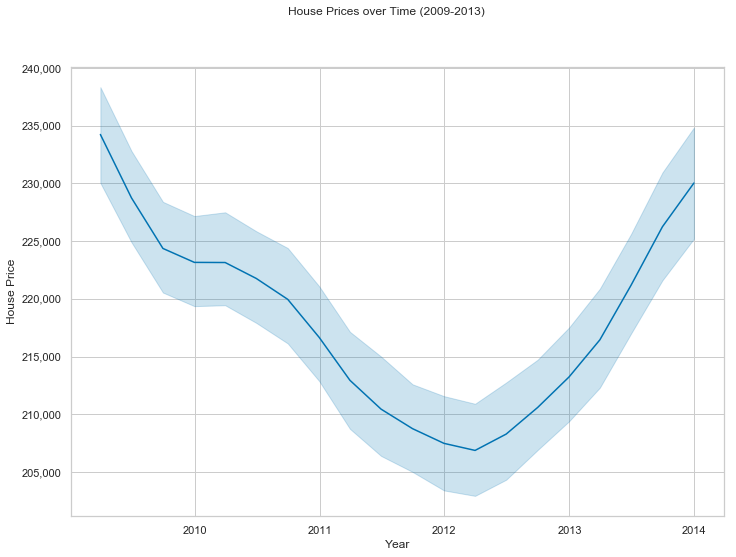

In [56]:
## Basic lineplot of the training data
## All zip codes, years 2009-2013
fig1, ax1 = plt.subplots(figsize=dims)
plot1 = sns.lineplot(x='YearMonth', y='HousePrice', data=df_09_13_aggQ)
fig1.suptitle('House Prices over Time (2009-2013)')
ax1.set_ylabel('House Price')
ax1.set_xlabel('Year')
ax1.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
#fig1.savefig('Lab2/images/HousePrice_2009_2013.png')

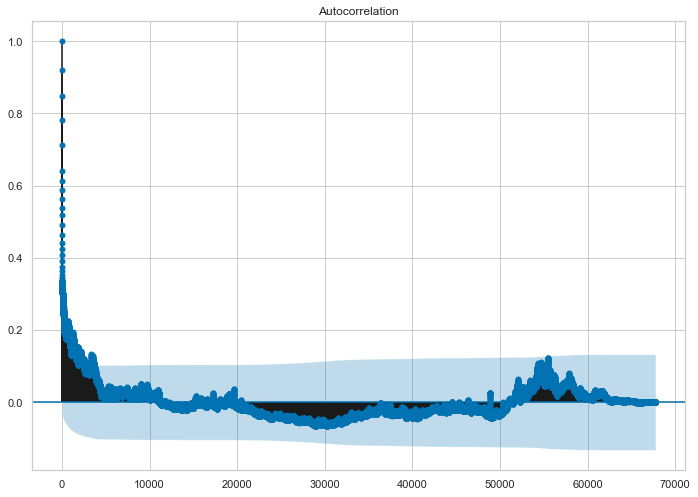

In [33]:
## ACF
fig2, ax2 = plt.subplots(figsize=dims)
acf_all = tsaplots.plot_acf(x=df_09_13_aggY['HousePrice'].values, ax=ax2)
#fig2.savefig('Lab2/images/ACF_2009_2013_all_by_year.png')


In [ ]:
## ACF for 60657 to see something slightly more useful
fig3, ax3 = plt.subplots(figsize=dims)
acf_single = tsaplots.plot_acf(x=df_09_13_aggQ[df_09_13_aggQ['RegionName'] == '60657']['HousePrice'].values, ax=ax3)
#fig3.savefig('Lab2/images/ACF_2009_2013_60657_by_year.png')


In [18]:
## Use $window periods to create a moving average
## Also specify how many periods to go out to
window = 2
forecast = 4

## Creating an empty df for the forecasted data
forecast_14 = pd.DataFrame(columns=['YearMonth', 'RegionName', 'HousePrice', 'MA'])

## Create a temp copy of the 2009-2013 by quarter df
tempdf_copy = df_09_13_aggQ.copy()

In [19]:
### Forecasts X periods forward based on a window of Y periods
### Drops values that are missing

### Takes about 2+ hrs to run

for zip in zips:
    countzip = tempdf_copy['RegionName'].str.contains(zip).sum()
    if countzip > 0:        
        temp_df = tempdf_copy[tempdf_copy['RegionName'] == zip]
        temp_df['MA'] = np.nan
        temp_df.reset_index(inplace=True, drop=True)
        
        for i in range(0, len(temp_df) + forecast):
            if i >= window:
                try:
                    t2 = temp_df.iloc[i-2]['HousePrice']
                    t1 = temp_df.iloc[i-1]['HousePrice']           
                    ma = round(1/2 * (t2 + t1), 0)
                    
                    ## If it's a forecast, create a new row
                    if i >= len(temp_df):
                        temp_df.loc[i] = [temp_df.iloc[i-1]['YearMonth'] + relativedelta(months=3),
                                          zip, temp_df.iloc[i-1]['MA'], ma]
                    else:
                        temp_df.at[i, 'MA'] = ma
                    
                except:
                    print("Can't find past values for {}".format(zip))
                    
            else:
                temp_df.at[i, 'MA'] = np.nan
                
        temp_df.dropna(inplace=True)
        forecast_14 = pd.concat([forecast_14, temp_df], ignore_index=True)
    else:
        print('{} is missing'.format(zip))

print(forecast_14)

### Values that turn up missing here:
# 97703 is missing
# 32163 is missing
# 75033 is missing
# 29486 is missing
# 84129 is missing
# 97003 is missing
# 84009 is missing
# 78599 is missing
# 49685 is missing
# 86005 is missing
# 99623 is missing
# 49696 is missing
# 93737 is missing
# 89034 is missing
# 76005 is missing
# 89155 is missing

C:\git\IST718\venv\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\git\IST718\venv\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\git\IST718\venv\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


97703 is missing


32163 is missing


75033 is missing


29486 is missing


84129 is missing


97003 is missing


84009 is missing


78599 is missing


49685 is missing


86005 is missing


99623 is missing


49696 is missing


93737 is missing


89034 is missing


76005 is missing


89155 is missing
        YearMonth RegionName     HousePrice        MA
0      2009-09-30      60657  777266.666667  804800.0
1      2009-12-31      60657  774200.000000  786300.0
2      2010-03-31      60657  776300.000000  775733.0
3      2010-06-30      60657  765966.666667  775250.0
4      2010-09-30      60657  759266.666667  771133.0
5      2010-12-31      60657  737866.666667  762617.0
6      2011-03-31      60657  729800.000000  748567.0
7      2011-06-30      60657  729866.666667  733833.0
8      2011-09-30      60657  733300.000000  729833.0
9      2011-12-31      60657  735800.000000  731583.0
10     2012-03-31      60657  734933.333333  734550.0
11     2012-06-30      60657  744933.333333  735367.0
12     2012-09-30      60657  770566.666667  739933.0
13     2012-12-31      60657  793566.666667  757750.0
14     2013-03-31      60657  806500.000000  782067.0
15     2013-06-30      60657  826966.666667  800033.0
16     2013-09-30      60657  851966.666667  816733.0
17     2013

In [20]:
forecast_comparison = pd.DataFrame(columns=['RegionName', 'Difference'])

for zip in zips:
    MA = forecast_14[(forecast_14['RegionName'] == zip) & (forecast_14['YearMonth'] == '2014-03-31')]['MA'].values
    actual = df_14_agg[df_14_agg['RegionName'] == zip]['HousePrice'].values
    try:
        diff = actual.item() - MA.item()
        forecast_comparison = forecast_comparison.append({'RegionName': zip, 'Difference': abs(diff)}, ignore_index=True)
    except:
        pass

print(forecast_comparison.head(n=5))


In [22]:
annual_forecast = forecast_14.copy()

annual_forecast.dropna(inplace=True)

annual_forecast['Difference'] = abs(annual_forecast['HousePrice'] - annual_forecast['MA'])

print(annual_forecast.head(n=5))

In [25]:
## Aggregating the forecast data to the year
annual_forecast_series = forecast_14.groupby(['RegionName', pd.Grouper(key='YearMonth', freq='Y')]).agg({'HousePrice': np.mean, 'MA': np.mean})
annual_forecast = annual_forecast_series.reset_index(level=0)
annual_forecast.reset_index(level=0, inplace=True)


In [26]:
## Export to CSV so I don't have to keep running time intensive code:

forecast_14.to_csv('Lab2\Forecast14.csv')
annual_forecast.to_csv('Lab2\AnnualForecast.csv')


## Read in CSVs
#forecast_14 = pd.read_csv('Lab2\Forecast14.csv', index_col=0, parse_dates=True)
#annual_forecast = pd.read_csv('Lab2\AnnualForecast.csv', index_col=0, parse_dates=True)

#forecast_14['YearMonth'] = pd.to_datetime(forecast_14['YearMonth'], format='%Y-%m-%d')
#forecast_14['RegionName'] = forecast_14['RegionName'].astype('str').apply(lambda x: x.zfill(5))
#annual_forecast['YearMonth'] = pd.to_datetime(annual_forecast['YearMonth'], format='%Y-%m-%d')
#annual_forecast['RegionName'] = annual_forecast['RegionName'].astype('str').apply(lambda x: x.zfill(5))

In [ ]:
fig4, ax4 = plt.subplots(figsize=dims)
plot4 = sns.lineplot(x='YearMonth', y='HousePrice', data=annual_forecast, label='Actual')
plot4 = sns.lineplot(x='YearMonth', y='MA', data=annual_forecast, label="MA 2")
fig4.suptitle('House Prices over Time (Actual vs MA-2)')
fig4.legend(loc='center right')
plot4.legend_.remove()
ax4.set_ylabel('House Price')
ax4.set_xlabel('Year')
ax4.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
#fig4.savefig('Lab2/images/HousePrice_OverTime_WithMA.png')


In [ ]:

## Calculating the growth from year over year for each zip
for i, row in annual_forecast.iterrows():
    year = row['YearMonth'].year
    zip = row['RegionName']
    
    if year == 2009:
        lastdiff = 0
        growth = 0
    else:
        lastyear = row['YearMonth'] - relativedelta(years=1)
        lastprice = round(annual_forecast[(annual_forecast['RegionName'] == zip) & (annual_forecast['YearMonth'] == lastyear)]['HousePrice'].values.item(),0)
        thisprice = round(row['HousePrice'],0)
        lastdiff = thisprice - lastprice
        growth = lastdiff / lastprice
    
    annual_forecast.set_value(i, 'DifferenceFromLastYear', lastdiff)
    annual_forecast.set_value(i, 'GrowthFromLastYear', growth)



In [49]:
for i, row in annual_forecast.iterrows():
    zip = row['RegionName']
    try:
        population = popbyzip_df[popbyzip_df['Zip'] == zip]['Population'].values.item()
    except:
        #print(zip)
        population = np.nan
    annual_forecast.set_value(i, 'Population', population)


In [66]:
for i, row in annual_forecast.iterrows():
    zip = row['RegionName']
    try:
        AGI = taxreturn_df[taxreturn_df['Zip'] == zip]['AGI'].values.mean().item()
    except:
        #print(zip)
        AGI = np.nan
    annual_forecast.set_value(i, 'AGI', AGI)


In [70]:
## Exporting the data prior to dropping nulls
annual_forecast.to_csv('Lab2/AnnualForecast_withPopAGI.csv')


In [97]:
## Creating a new array with nulls from the AGI and Population merge.
annual_nulls = annual_forecast[annual_forecast.isnull().any(axis=1)]['RegionName'].unique()

## Saving all of the dropped Zips in a csv
dropped_zips = pd.DataFrame(np.concatenate((dropped_zips, annual_nulls), axis=0), columns=['Zips'])
dropped_zips.to_csv('Lab2/Dropped_Zips.csv', index=False)

## Dropping the nulls from the forecasted df
annual_forecast.dropna(inplace=True)

In [130]:
## Comparing the MA forecast to 2014 Q1 actuals
## Calculating RMSQ and MAE for the comparison
temp14_df = forecast_14[forecast_14['YearMonth'] == '2014-03-31']
df_14_merged = pd.merge(right=df_14_agg, left=temp14_df[['RegionName', 'MA']], how='right', on='RegionName')

MA14_RMSE = sqrt(mean_squared_error(y_true=df_14_merged['HousePrice'], y_pred=df_14_merged['MA']))
MA14_MAE = mean_absolute_error(y_true=df_14_merged['HousePrice'], y_pred=df_14_merged['MA'])
print('Moving Average RMSE for only 2014 predictions: {}'.format(round(MA14_RMSE,2)))
print('Moving Average MAE for only 2014 predictions: {}'.format(round(MA14_MAE,2)))


## Calculating the RMSE and MAE for all MA predictions
MA_RMSE = sqrt(mean_squared_error(y_true=annual_forecast['HousePrice'], y_pred=annual_forecast['MA']))
MA_MAE = mean_absolute_error(y_true=annual_forecast['HousePrice'], y_pred=annual_forecast['MA'])
print('Moving Average RMSE for all predictions: {}'.format(round(MA_RMSE,2)))
print('Moving Average MAE for all predictions: {}'.format(round(MA_MAE,2)))

Moving Average RMSE for only 2014 predictions: 18668.82
Moving Average MAE for only 2014 predictions: 5863.53
Moving Average RMSE for all predictions: 9836.96
Moving Average MAE for all predictions: 4129.22


C:\git\IST718\venv\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\git\IST718\venv\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


       YearMonth RegionName    HousePrice        MA  DifferenceFromLastYear  \
34498 2013-12-31      35805  49016.666667  44670.75                 15059.0   
70210 2013-12-31      89107  96983.333333  83891.75                 26841.0   
70222 2013-12-31      89110  94916.666667  83141.50                 24009.0   
70234 2013-12-31      89115  84975.000000  75575.00                 21358.0   
70204 2013-12-31      89104  96483.333333  86083.25                 23500.0   
54124 2013-12-31      61723  80475.000000  73025.00                 18925.0   
44320 2013-12-31      48220  82941.666667  73375.00                 19150.0   

       GrowthFromLastYear  Population            AGI  
34498            0.443460     22498.0   38018.500000  
70210            0.382667     36282.0  134066.500000  
70222            0.338594     70994.0  180284.500000  
70234            0.335728     58794.0  109930.833333  
70204            0.321993     39909.0   94267.500000  
54124            0.307474      2321.0

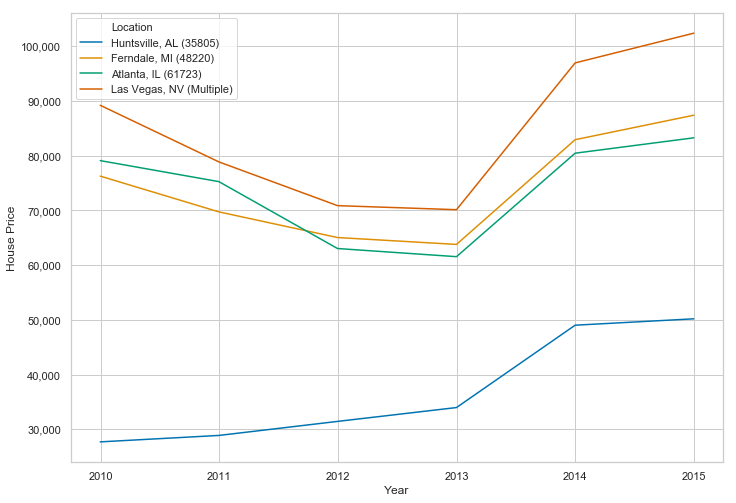

In [188]:
## Zips that showed 30% growth and were priced less than 100k last year
# 35805 Huntsville, AL
# 89107 Las Vegas, NV
# 89110 Las Vegas, NV
# 89115 Las Vegas, NV
# 89104 Las Vegas, NV
# 61723 Atlanta, IL
# 48220 Ferndale, MI

MA_top_zips_df = annual_forecast[(annual_forecast['GrowthFromLastYear'] >= 0.30) & (annual_forecast['HousePrice'] <= 100000)].sort_values(by='GrowthFromLastYear', ascending=False)
MA_top_zips_only = MA_top_zips_df['RegionName'].unique()
MA_top_zips_overtime = annual_forecast[(annual_forecast['RegionName'] == '35805') | \
                                       (annual_forecast['RegionName'] == '89107') | \
                                       (annual_forecast['RegionName'] == '61723') | \
                                       (annual_forecast['RegionName'] == '48220')]
for i, row in MA_top_zips_overtime.iterrows():
    if row['RegionName'] == '35805':
        MA_top_zips_overtime.at[i, 'Location'] = 'Huntsville, AL ({})'.format(row['RegionName'])
    elif row['RegionName'] == '61723':
        MA_top_zips_overtime.at[i, 'Location'] = 'Atlanta, IL ({})'.format(row['RegionName'])
    elif row['RegionName'] == '48220':
        MA_top_zips_overtime.at[i, 'Location'] = 'Ferndale, MI ({})'.format(row['RegionName'])
    else:
        MA_top_zips_overtime.at[i, 'Location'] = 'Las Vegas, NV (Multiple)'

print(MA_top_zips_df)

fig5, ax5 = plt.subplots(figsize=dims)
plot5 = sns.lineplot(y='HousePrice', x='YearMonth', data=MA_top_zips_overtime, hue='Location')
ax5.set_ylabel('House Price')
ax5.set_xlabel('Year')
ax5.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
#fig5.savefig('Lab2/images/MA_TopZipsOverTime.png')



In [23]:
## Creating a copy of the quarterly df for RF
## Filling it in with population and AGI
## Dropping NA values

taxreturn_df = pd.DataFrame(taxreturn_df.groupby(by='Zip')['AGI'].mean())
taxreturn_df.reset_index(level=0, inplace=True)
taxreturn_df['Zip'] = taxreturn_df['Zip'].astype('str').apply(lambda x: x.zfill(5))

rf_quarterly = df_09_13_aggQ.copy()

rf_quarterly = pd.merge(left=rf_quarterly, right=popbyzip_df,
                        left_on='RegionName', right_on='Zip', how='left')

rf_quarterly = pd.merge(left=rf_quarterly, right=taxreturn_df,
                        left_on='RegionName', right_on='Zip', how='left')

drop_cols = ['Zip_x', 'Zip_y',]
rf_quarterly.drop(columns=drop_cols, inplace=True)
rf_quarterly.dropna(inplace=True)

In [25]:
## Creating a 2014 test set for verification
rf_df_14 = df_14_agg.copy()

rf_df_14 = pd.merge(left=rf_df_14, right=popbyzip_df,
                        left_on='RegionName', right_on='Zip', how='left')

rf_df_14 = pd.merge(left=rf_df_14, right=taxreturn_df,
                        left_on='RegionName', right_on='Zip', how='left')
drop_cols = ['Zip_x', 'Zip_y',]
rf_df_14.drop(columns=drop_cols, inplace=True)
rf_df_14.dropna(inplace=True)


In [64]:
## Creating a df with just 2013 annual data
df_2013 = df_09_13_aggY[df_09_13_aggY['YearMonth'] == '2013-12-31']

df_2013 = pd.merge(left=df_2013, right=popbyzip_df,
                        left_on='RegionName', right_on='Zip', how='left')

df_2013 = pd.merge(left=df_2013, right=taxreturn_df,
                        left_on='RegionName', right_on='Zip', how='left')
drop_cols = ['Zip_x', 'Zip_y',]
df_2013.drop(columns=drop_cols, inplace=True)
df_2013.dropna(inplace=True)

In [74]:
## Copying df just in case
## Creating the test/train split as 30/70
## Dropping label 
rf_quarterly_cp = rf_quarterly.copy()

labels = np.array(rf_quarterly_cp['HousePrice'])
rf_quarterly_cp.drop('HousePrice', axis=1, inplace=True)
rf_quarterly_cp.drop('YearMonth', axis=1, inplace=True)

train_data, test_data, train_labels, test_labels = train_test_split(rf_quarterly_cp, labels, test_size=0.3, random_state=1000)

rf = RandomForestRegressor(n_estimators=100, random_state=1000)


In [75]:
## Fitting the test data and doing the prediction
rf.fit(train_data, train_labels)

predictions = rf.predict(test_data)

Moving Average RMSE for all predictions: 27275.74
Moving Average MAE for all predictions: 11401.44


In [76]:
## RMSE and MAE for 2009-2013 RF prediction
RF_RMSE = sqrt(mean_squared_error(y_true=test_labels, y_pred=predictions))
RF_MAE = mean_absolute_error(y_true=test_labels, y_pred=predictions)
print('Moving Average RMSE for all predictions: {}'.format(round(RF_RMSE,2)))
print('Moving Average MAE for all predictions: {}'.format(round(RF_MAE,2)))



Moving Average RMSE for all predictions: 27275.74
Moving Average MAE for all predictions: 11401.44


In [39]:
## RF prediction and checking against the actual 2014 data
labels_2014 = np.array(rf_df_14['HousePrice'])
data_2014 = rf_df_14.copy()
data_2014.drop('HousePrice', axis=1, inplace=True)
data_2014.drop('YearMonth', axis=1, inplace=True)

predictions_2014 = rf.predict(data_2014)

Moving Average RMSE for all predictions: 27275.74
Moving Average MAE for all predictions: 11401.44


In [40]:
## RMSE and MAE for 2014 predictions
RF2014_RMSE = sqrt(mean_squared_error(y_true=labels_2014, y_pred=predictions_2014))
RF2014_MAE = mean_absolute_error(y_true=labels_2014, y_pred=predictions_2014)
print('Moving Average RMSE for all predictions: {}'.format(round(RF2014_RMSE,2)))
print('Moving Average MAE for all predictions: {}'.format(round(RF2014_MAE,2)))


Moving Average RMSE for all predictions: 27275.74
Moving Average MAE for all predictions: 11401.44


In [54]:

pred_df = pd.DataFrame(predictions, columns=['RF_Prediction'])
pred_df.reset_index(level=0, inplace=True, drop=True)

data_2014_all = rf_df_14.copy()
data_2014_all.reset_index(level=0, inplace=True, drop=True)
data_2014_all = pd.merge(left=data_2014_all, right=pred_df, left_index=True, right_index=True)


80712


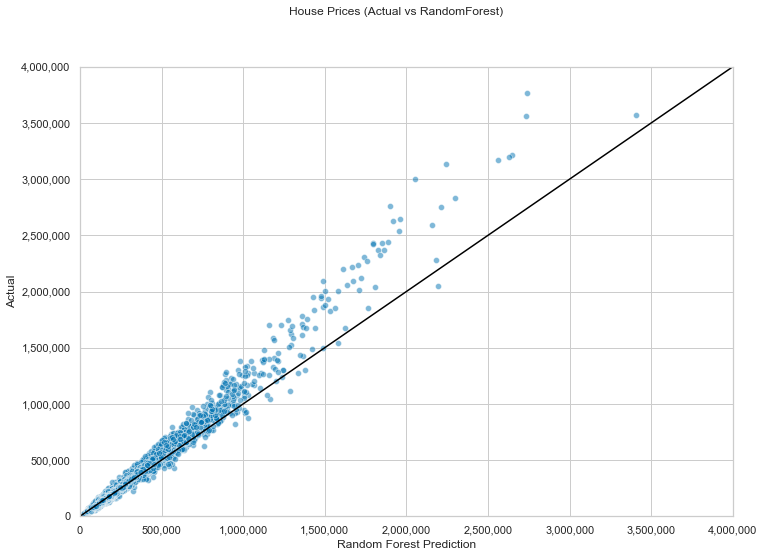

In [97]:
## Merging the predictions back into the main df
df_14_all = rf_df_14.copy()
df_14_all.reset_index(level=0, inplace=True, drop=True)
pred_2014_df = pd.DataFrame(predictions_2014, columns=['RF_Prediction'])

df_14_all = pd.merge(left=df_14_all, right=pred_2014_df, how='left',
                   left_index=True, right_index=True)


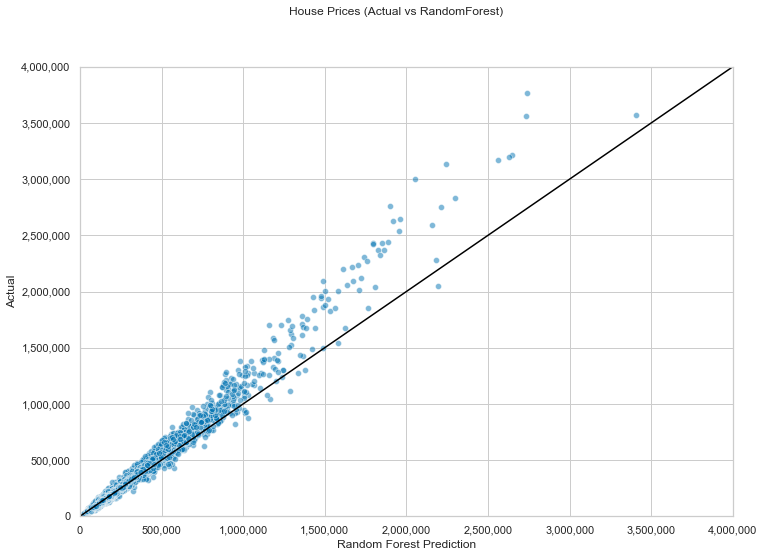

In [112]:
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

## Plotting the predictions vs the actuals
fig6, ax6 = plt.subplots(figsize=dims)
plot6 = sns.scatterplot(x='RF_Prediction', y='HousePrice', data=df_14_all, alpha=0.5)
line6 = mlines.Line2D([0,1], [0,1], color='black')
transform = ax6.transAxes
line6.set_transform(transform)
ax6.add_line(line6)
fig6.suptitle('House Prices (Actual vs RandomForest)')
ax6.set_ylim(0,4000000)
ax6.set_xlim(0,4000000)
ax6.set_ylabel('Actual')
ax6.set_xlabel('Random Forest Prediction')
ax6.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax6.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
#fig6.savefig('Lab2/images/HousePrices_ActualvsRF.png')


In [132]:
## Creating a copy of the 2009 to 2013 yearly 
df2013_year = df_09_13_aggY.copy()
df_14_all_temp = df_14_all[['YearMonth', 'RegionName', 'RF_Prediction']]
df_14_all_temp['YearMonth'] = pd.to_datetime('2014-12-31', format='%Y-%m-%d')
df_14_all_temp.rename(columns={'RF_Prediction': 'HousePrice'}, inplace=True)
df2013_2014 = pd.concat([df2013_year, df_14_all_temp])
df2013_2014.sort_values(by=['RegionName', 'YearMonth'], inplace=True)
df2013_2014.reset_index(level=0, inplace=True, drop=True)


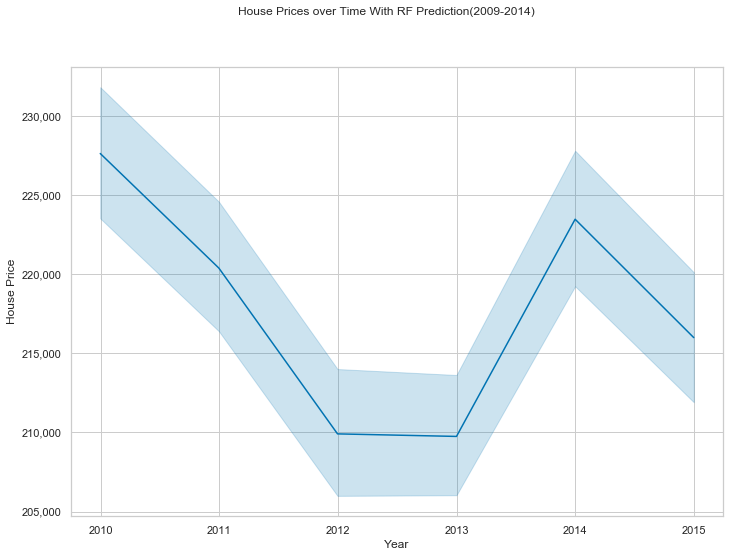

In [135]:
## Basic lineplot of the training data
## All zip codes, years 2009-2014
fig7, ax7 = plt.subplots(figsize=dims)
plot7 = sns.lineplot(x='YearMonth', y='HousePrice', data=df2013_2014)
fig7.suptitle('House Prices over Time With RF Prediction(2009-2014)')
ax7.set_ylabel('House Price')
ax7.set_xlabel('Year')
ax7.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
#fig7.savefig('Lab2/images/HousePrice_2009_2014_withRF.png')

In [137]:
## Calculating the growth from year over year for each zip
for i, row in df2013_2014.iterrows():
    year = row['YearMonth'].year
    zip = row['RegionName']
    
    if year == 2009:
        lastdiff = 0
        growth = 0
    else:
        lastyear = row['YearMonth'] - relativedelta(years=1)
        lastprice = round(df2013_2014[(df2013_2014['RegionName'] == zip) & (df2013_2014['YearMonth'] == lastyear)]['HousePrice'].values.item(),0)
        thisprice = round(row['HousePrice'],0)
        lastdiff = thisprice - lastprice
        growth = lastdiff / lastprice
    
    df2013_2014.at[i, 'DifferenceFromLastYear'] = lastdiff
    df2013_2014.at[i, 'GrowthFromLastYear'] = growth



C:\git\IST718\venv\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\git\IST718\venv\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


       YearMonth RegionName    HousePrice  DifferenceFromLastYear  \
52643 2014-12-31      60411  90076.622857                 33285.0   
69253 2014-12-31      85631  68783.853912                 25292.0   
18511 2014-12-31      19134  37847.400585                 12330.0   
37283 2014-12-31      39567  90716.534428                 28950.0   
34469 2013-12-31      35805  49016.666667                 15059.0   
41956 2014-12-31      46203  50596.759752                 15497.0   
39387 2014-12-31      44102  35058.998355                 10667.0   
42004 2014-12-31      46226  60145.637558                 17996.0   
28944 2014-12-31      31217  41735.930369                 12328.0   
48043 2014-12-31      53218  67314.656682                 19257.0   
52631 2014-12-31      60409  77013.938038                 21431.0   
70162 2013-12-31      89107  96983.333333                 26841.0   
18547 2014-12-31      19142  51816.048790                 14333.0   
39231 2014-12-31      44052  61757

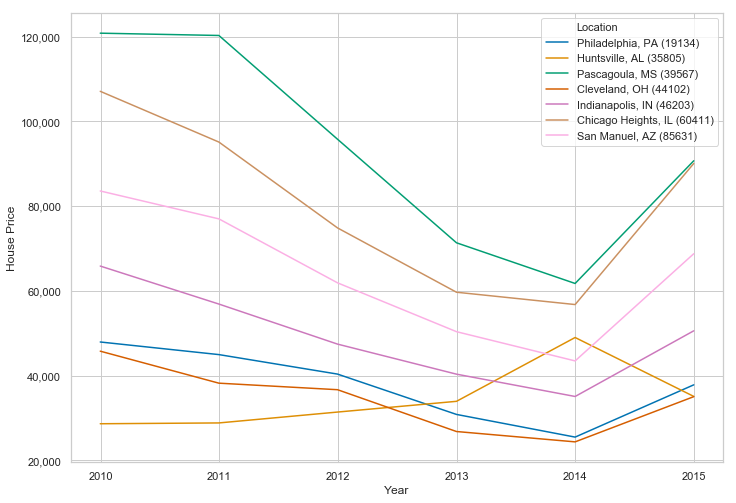

In [151]:
## Zips that showed 30% growth and were priced less than 100k last year
# 60411 Chicago Heights, IL
# 85631 San Manuel, AZ
# 19134 Philadelphia, PA
# 39567 Pascagoula, MS
# 35805 Huntsville, AL
# 46203 Indianapolis, IN
# 44102 Cleveland, OH

RF_top_zips_df = df2013_2014[(df2013_2014['GrowthFromLastYear'] >= 0.30) \
                             & (df2013_2014['HousePrice'] <= 100000)].sort_values(by='GrowthFromLastYear', ascending=False)
RF_top_zips_only = RF_top_zips_df['RegionName'].unique()
RF_top_zips_overtime = df2013_2014[(df2013_2014['RegionName'] == '60411') | \
                                       (df2013_2014['RegionName'] == '85631') | \
                                       (df2013_2014['RegionName'] == '19134') | \
                                       (df2013_2014['RegionName'] == '39567') | \
                                       (df2013_2014['RegionName'] == '35805') | \
                                       (df2013_2014['RegionName'] == '46203') | \
                                       (df2013_2014['RegionName'] == '44102')]
for i, row in RF_top_zips_overtime.iterrows():
    if row['RegionName'] == '60411':
        RF_top_zips_overtime.at[i, 'Location'] = 'Chicago Heights, IL ({})'.format(row['RegionName'])
    elif row['RegionName'] == '85631':
        RF_top_zips_overtime.at[i, 'Location'] = 'San Manuel, AZ ({})'.format(row['RegionName'])
    elif row['RegionName'] == '19134':
        RF_top_zips_overtime.at[i, 'Location'] = 'Philadelphia, PA ({})'.format(row['RegionName'])
    elif row['RegionName'] == '39567':
        RF_top_zips_overtime.at[i, 'Location'] = 'Pascagoula, MS ({})'.format(row['RegionName'])
    elif row['RegionName'] == '35805':
        RF_top_zips_overtime.at[i, 'Location'] = 'Huntsville, AL ({})'.format(row['RegionName'])
    elif row['RegionName'] == '46203':
        RF_top_zips_overtime.at[i, 'Location'] = 'Indianapolis, IN ({})'.format(row['RegionName'])
    elif row['RegionName'] == '44102':
        RF_top_zips_overtime.at[i, 'Location'] = 'Cleveland, OH ({})'.format(row['RegionName'])
    else:
        pass

fig8, ax8 = plt.subplots(figsize=dims)
plot8 = sns.lineplot(y='HousePrice', x='YearMonth', data=RF_top_zips_overtime, hue='Location')
ax8.set_ylabel('House Price')
ax8.set_xlabel('Year')
ax8.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
#fig8.savefig('Lab2/images/RF_TopZipsOverTime.png')